In [1]:
import os  # Import os to handle folders and files
import time  # Import module to check code time executing
import random  # Import module to do pseudo-random numbers
import numpy as np  # Import numpy module to read tables, manage data, etc
from scripts import main  # Import main script
from prettytable import PrettyTable  # Import module to do tables

# T-distributed Stochastic Neighbor Embedding (t-SNE) in Swift Data
## Introduction
As suggested by [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract), Swift GRBs can be separated into two groups when t-SNE is performed. In this Jupyter notebook, we replicate this work by adding more recent data and an in-depth analysis of t-SNE performance. Moreover, we hope to add synthetic GRB performed using Machine Learning instances and join into Swift and other GRB data packages.

Through this document, we will use two scripts named `main.py` and `helpers.py`, the first script do the main things about implementing tSNE and preparing the data, while the last only do some repetitive tasks and minor jobs. Before continuing, the `main.py` script needs to download some tables previously to work, doing this is so easy, you only need to use the `summary_tables_download` instance in `main.py`, but, before doing this, you need to create an object to initialize `SwiftGRBWorker` class:

In [2]:
%matplotlib inline
object1 = main.SwiftGRBWorker()
# object1.summary_tables_download()  # Comment this line if you already have downloaded the tables

## Swift Data Download
First of all, we need to download all the data from [Swift Database](https://swift.gsfc.nasa.gov/results/batgrbcat/) to prepare them to perform t-SNE. For this, we want first to download only data for one GRB, then it is needed to use `download_data` instance from `main.py` class and pass it a name, TRIGGER_ID, and observation resolution, that we get from `summary_general` table:

In [3]:
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True, autostrip=True)
print(f"There are {len(GRB_names)} in summary table")
print(f"Names: {GRB_names}")
print(f"IDs: {ids}")

There are 1391 in summary table
Names: ['GRB200829A' 'GRB200819A' 'GRB200809B' ... 'GRB041219B' 'GRB041219A'
 'GRB041217']
IDs: ['993768' '992099' '987745' ... '100368' '100307' '100116']


Now, download $64ms$ data for a random GRB listed before:

In [ ]:
# result_GRB = [[], []]  # Comment this line if you already have downloaded the data, and you need to customize any GRB
result_GRB = ['GRB060614', None]  # Put Any customized GRB here
while result_GRB[1] is not None:
    random_position = random.randint(0, len(GRB_names))
    result_GRB = object1.download_data(GRB_names[random_position], ids[random_position])
    print(f"{result_GRB[0]} has been downloaded") if not result_GRB[1] else print(f"Error downloading {GRB_names[random_position]} data")

When we see the GRB table, we note the following columns:
* Time since BAT Trigger time (s)
* Intensity and its error in bands 15-25keV, 25-50keV, 50-100keV, 100-350keV, 15-350keV in counts/sec/det

In [ ]:
x = PrettyTable()  # Create printable table
original_data_path = object1.original_data_path
data = np.genfromtxt(os.path.join(original_data_path, f"{result_GRB[0]}_{64}ms.gz"), autostrip=True)  # Read data
column_names = ('Time (s)', '15-25keV', 'Error', '25-50keV', 'Error', '50-100keV', 'Error', '100-350keV', 'Error','15-350keV', 'Error')
[x.add_column(column_names[i], np.round(data[:3, i], 3)) for i in range(len(data[0]))]  # Add initial 3 rows to each column
x.add_row(['...']*len(column_names))  # Add dots space
x.add_rows(np.round(data[-3:-1], decimals=3))  # Add last 2 rows to each column
print(x)

Additionally, if you want to plot the original light curves for this GRB, you can use the `plot_any_grb` function using the argument _t_ in False (indicating that you don't need to filter the LC). In this case, it takes the form:

In [ ]:
fig, axes = object1.plot_any_grb(result_GRB[0], t=False)  # Plot all extension of Light Curve

Now, if you need to download hundreds of data files (that is my case), it is faster to do Threading over all names and IDs that loop one by one (e.g. `for` instance), so you can indeed use `so_much_downloads` function:

In [ ]:
if None:  # Change None to any True variable in this statement if you need to download data (by first time using by example)
    time1 = time.perf_counter()
    object1.so_much_downloads(GRB_names, ids)
    time2 = time.perf_counter()
    GRB_errors = np.genfromtxt(os.path.join(original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
    print(f"Downloaded {len(GRB_names)-len(GRB_errors)} light curves in {round(time2-time1, 2)}s (Total = {len(GRB_names)})")

If you get some _HTTPSConnectionPool_ in the errors summary file, you can run the following code lines as many times as you need:

In [ ]:
GRB_errors_name, desc = np.genfromtxt(os.path.join(original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)
match = np.where(np.isin(GRB_names, GRB_errors_name))[0]
object1.so_much_downloads(GRB_names[match], t_ids=ids[match])

As you saw, this function can take a little time to run, but it is so much faster than loop using `for` instance. Additionally, some GRBs could not be downloaded, you can check them using the `Errors.txt` file, we want to delete this GRBs for the total name list:

In [ ]:
GRB_errors = np.genfromtxt(os.path.join(original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
print(f'{len(GRB_errors)} GRBs get download error: {GRB_errors}')
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]
Initial_GRB_names = GRB_names  # Array with all initial GRBs downloaded

In summary, these errors occur for two reasons:
* First, the GRB doesn't have any Trigger ID
* Second, the GRB has Trigger ID, but it doesn't have any data to download

By this, we close this section by remarking that original size data can use 2.67GB of free space on disk approximately (in decompress mode). But, compressing data using `gzip` library, now:

In [ ]:
size = 0  # Set size variable to zero
for path, dirs, files in os.walk(object1.original_data_path):  # Loop over the folder containing all data downloaded
    for f in files:  # Loop over files into folder
        fp = os.path.join(path, f)  # Join file name with folder path
        size += os.stat(fp).st_size  # Get file size and sum over previous size
print(f"There are {round(size/(1024*1024), 3)} MB of data")

# Swift Data Pre-processing
Now, we want to process the data to prepare it for tSNE implementation. This process consists of 4 phases, following:
* Limit all GRBs out of $T_{100}$
* Normalize light curves (lc) by total fluence in 15-350keV band
* Pad with zeros all GRBs, putting then in the same time standard basis
* Concatenate data from all bands and perform DFT to get Fourier amplitude spectrum

In the next sections, we are going to describe these processes and show how to use some functions to do these steps.

## First step: Limit lc out of $T_{100}$
In this step, we need to extract the durations for all GRBs available in `summary_burst_durations.txt` using the `durations_checker` instance. If you don't pass any GRB name, this function returns a list containing three values for each GRB in the table: Name, $T_{i}$ start and end times (in seconds), where $i$ can be 50, 90, or 100 (default value), but if you pass it a name, then it returns these values only by this GRB:

In [ ]:
durations_times = object1.durations_checker(result_GRB[0])
print(f"{durations_times[0, 0]} has T_100={round(float(durations_times[0, 2])-float(durations_times[0, 1]), 3)}s (T_100 start={durations_times[0, 1]}s, T_100 end={durations_times[0, 2]}s)")

With these values, we can limit our GRB lc using the instance `lc_limiter`.  In this function, it is possible directly set the time limiters in seconds or pass it an integer to indicate what duration we need (however, these integers can be only 50, 90, and 100). So, we try to extract the lc out of $T_{100}$ by using an integer and setting limits manually, then comparing both:

In [ ]:
limited_data_1 = object1.lc_limiter(result_GRB[0])  # Limiting by T_100
limited_data_2 = object1.lc_limiter(result_GRB[0], limits=(durations_times[0, 1], durations_times[0, 2]))  # By values
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_2)}")
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(limited_data_1[:3], decimals=3))  # Add first 3 rows to each column
x.add_row(['...']*len(column_names))  # Add dots space
x.add_rows(np.round(limited_data_1[-3:-1], decimals=3))  # Add last 2 rows to each column
print(x)

Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Graphically, the lc out of $T_{100}$ is:

In [ ]:
fig_limited, axes_limited = object1.plot_any_grb(result_GRB[0], t=100)  # Plot Light Curve out of T_100

So, the next step is to do this for all downloaded GRBs, to get a much faster performance of execution, we can use the `so_much_lc_limiters` function:

In [ ]:
y = PrettyTable()  # Create printable table
time1 = time.perf_counter()
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)
time2 = time.perf_counter()
print(f"{len(limited_data)} GRBs limited in {round(time2-time1, 2)}s ({len(errors)} Errors)")
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)

As you see, the function returns a tuple of limited arrays and errors for all GRBs. In this case, 51 GRBs have any of the following errors:
* _FileNotFoundError_ if GRB does not have any data file downloaded in the selected resolution.
* _ValueError_ if the code can't get any limit values.
* _IndexError_ if the GRB does not appear in the `summary_burst_durations` table.
* _Length={value}_ if the limited GRB data has less than three discrete points.
* _Only zeros_ if the limited GRB data only has zeros.

Additionally, the second argument returned by `so_much_lc_limiters` is a GRB names array indicating the order of results (the first argument returned). This order is now our `GRB_names` variable because it does not have the error names.

To check if the `so_much_lc_limiters` instance is doing its job well, we are going to compare (for the random GRB selected before) if the data stored in _limited_data_1_ and obtained in parallelizing are equal:

In [ ]:
random_index = GRB_names.index(result_GRB[0])  # Search random GRB in new GRB names list
limited_data_random_GRB = np.array(limited_data[random_index])  # Extract limited values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_random_GRB)}")

## Second step: Normalizing Light Curves
GRBs have one fact that is widely known: long GRBs typically but not always has higher fluence. To avoid t-SNE being distracted by this fact, we need to normalize our lc by total time-integrated flux, `lc_normalizer` instance does this job by using the Simpson's Rule in any array. This function returns a tuple normalized data, total time-integrated flux if _print_area_ parameter is _True_, otherwise only returns normalized data:

In [ ]:
normalized_data_random_GRB, total_flux = object1.lc_normalizer(limited_data_random_GRB, print_area=True)
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(normalized_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(normalized_data_random_GRB[np.r_[-2:0]], decimals=4))  # Add new rows of limited data
print(f"Total time-integrated flux for {result_GRB[0]} is: {round(total_flux, 4)}")
print(x)

Note that normalized data are only limited data divided by 15-350keV integrated flux. So, the next step is to do this for all limited GRBs, to get a much faster performance of execution, we can use the `so_much_normalize` function. To check if this instance is doing its job well, we are going to compare (for the random GRB selected before) if the data stored in _normalized_data_random_GRB_ and obtained in parallelizing are equal:

In [ ]:
normalized_data = object1.so_much_normalize(limited_data)  # Normalizing all light curves
normalized_data_random_GRB_2 = normalized_data[random_index]  # Extract normalized values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(normalized_data_random_GRB, normalized_data_random_GRB_2)}")

## Third step: Zero Padding
With all GRBs limited out of $T_{100}$ and normalized, we need now to zero-pad their light curves to place them on the same time basis. The `zero_pad` instance performs this job by checking the max length of a data set and looking for the best suitable array size to do Fast Fourier Transform (FFT, the next step in data pre-processing).

Here, we are going to see how this function zero pad the data at its end for the random selected GRB before:

In [ ]:
zero_padded_data = object1.so_much_zero_pad(normalized_data)
zero_padded_data_random_GRB = zero_padded_data[random_index]
print(f"Best FFT suitable data length: {len(zero_padded_data_random_GRB)}")
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(zero_padded_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[len(normalized_data_random_GRB)-2:len(normalized_data_random_GRB)+2], decimals=4))  # Add new end rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[-3:-1], decimals=4))  # Add new end rows of limited data
print(x)

## Final Step: Discrete Fourier Transform
Finally, the last step of Swift data pre-processing is to perform a Fast Fourier Transform to zero-padded normalized data out of $T_{100}$. There are so many python packages to do this job, particularly in this notebook, we are going to use _scipy_ in the `fourier_concatenate` instance, but before that, this function concatenate all energy band measurements in one single array, as required to execute DFT:

In [ ]:
dft_random_GRB, dft_fig = object1.fourier_concatenate(zero_padded_data[random_index], plot=True, name=result_GRB[0])

Note that DFT data is below the Nyquist frequency, following the Nyquist-Shannon sampling theorem:

_The Nyquist-Shannon sampling theorem states that a signal sampled at a rate can be fully reconstructed if it contains only frequency components below half that sampling frequency. Thus the highest frequency output from the DFT is half the sampling rate._

With this, we can now calculate DFT for the entire zero-padded dataset using the `so_much_fourier` instance:

In [ ]:
pre_processing_data = object1.so_much_fourier(zero_padded_data)

Finally, the pre-processing data stage is over. Then, we want to save all data in a compressed format to load in the next section. For this, you can use the `save_data` function (based in `savez_compressed` instance of Numpy):

In [ ]:
object1.save_data(f"DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=pre_processing_data)

# t-SNE in Swift Data
t-Distributed Stochastic Neighbor Embedding (or t-SNE) is a popular non-linear dimensionality reduction technique used for visualizing high dimensional data sets. After pre-processing Swift data in the $x_i$ vectors with Fourier Amplitudes, we want to perform this method by taking so much care when we read the results. Why? The t-SNE algorithm doesn’t always produce similar output on successive runs, and it depends on some hyperparameters related to the optimization process.

In this study, the most relevant hyperparameters on the cost function are (following the scikit-Learn and open-TSNE packages documentation):
* __Perplexity__: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Note that perplexity linearly impacts runtime i.e. higher values of perplexity will incur longer execution time.
* __learning_rate__: The learning rate controls the step size of the gradient updates. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers.
* __metric__: The metric to use when calculating distance between instances in a feature array.

## t-SNE convergency
First of all, we want to see how t-SNE converges in the pre-processed data. To do this, we use the `convergence_animation` function, it is based in [tsne_animate](https://github.com/sophronesis/tsne_animate) package from GitHub in its `tsne_animation` function. But, before we need to load the pre-processing data saved:

In [ ]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
print(f"There are {len(GRB_names)} GRBs loaded: {GRB_names}")

Now, we will index GRBs durations (using the `durations_checker` instance) to see the results dependence with this feature:

In [ ]:
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start

Then we set the standard _perplexity_ value (30) from [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract), set auto _learning rate_ in scikit-Learn t-SNE implementation, and perform the animation:

In [ ]:
file_name = os.path.join('README_files', 'convergence_animation_pp_30.gif')
object1.convergence_animation(features, filename=file_name, perplexity=30, duration_s=durations)

![](README_files/convergence_animation_pp_30.gif)

And repeat the same with perplexity = 4

In [ ]:
file_name = os.path.join('README_files', 'convergence_animation_pp_4.gif')
object1.convergence_animation(features, filename=file_name, perplexity=4, duration_s=durations)

![](README_files/convergence_animation_pp_4.gif)

As you can see, there is a clear dependence on $T_{90}$ duration and GRB position in the final plot (except for some GRBs, i. e. GRB190718A). Additionally, we can see that after iteration 250, the scatter pattern converges so fast. It is because (after this iteration) the TSNE instance in _scikit Learn_ updates the Kullback–Leibler divergence and `early_exaggeration` parameter.

To do more complex analysis, we can highlight custom GRBs, see redshift dependence in marker size (however, there isn't much redshift info in Swift data), and configure the TSNE running instance. For example, the tSNE convergence setting $215$ in _perplexity_, 'auto' in _learning_rate_, and 'cosine' as metric follows:

In [ ]:
file_name = os.path.join('README_files', 'convergence_animation_2.gif')
object1.convergence_animation(features, filename=file_name, perplexity=215, learning_rate='auto', metric='cosine', duration_s=durations)

![](README_files/convergence_animation_2.gif)

and for the same conditions at perplexity = $5$:

In [ ]:
file_name = os.path.join('README_files', 'convergence_animation_3.gif')
object1.convergence_animation(features, filename=file_name, perplexity=5, learning_rate='auto', metric='cosine', duration_s=durations)

![](README_files/convergence_animation_3.gif)

## tSNE Hyperparameter review

As pioneered by [Wattenberg et al. 2016](https://distill.pub/2016/misread-tsne/), tSNE results cannot be understood only by seeing one scatter plot in 2D. As they said: "_Getting the most from t-SNE may mean analyzing multiple plots with different perplexities._" For this job, you can use the `tsne_animation` instance to iterate over any hyperparameter in sklearn or openTSNE, for example, setting default values in sklearn tSNE and iterating over **perplexity** $\in$ $[4, 500]$:

In [ ]:
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', 'perplexity_animation.gif')
object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, filename=file_name)

![](README_files/perplexity_animation.gif)

Note that in some perplexities (i. e. 150), there are "pinched" shapes in the middle plot region. Following [Wattenberg et al. 2016](https://distill.pub/2016/misread-tsne/) analysis: _"chances are the process was stopped too early"_ or this may be because the t-SNE algorithm gets stuck in a bad local minimum.

In general, lower perplexities focus on the substructure of data, and higher perplexities plots are less sensitive to small structures. By contrast, the plot structure does not change globally after perplexity = 200 (except for pinched runs), so we can use this value as default in the following hyperparameters.

The reason why high perplexity values converge better is that noisier datasets (as Swift) will require larger perplexity values to encompass enough local neighbors to see beyond the background noise (see [optimizing tSNE sklearn section](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)).

However, at low perplexities (below 20), there are two separated groups of GRBs with significantly different duration $T_{90}$ values. This is because tSNE searches only ten to twenty neighbors for each GRB and can distinguish between these two groups. Then we can use perplexity < 10 as another default value too.

Now, we can see what happens if **learning_rate** changes within $10$ and $1000$ (values recommended in [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)):

In [ ]:
lr = np.arange(10, 1000, 75)
file_name = os.path.join('README_files', 'learning_rate_animation.gif')
object1.tsne_animation(features, duration_s=durations, perplexity=245, filename=file_name, iterable='learning_rate', learning_rate=lr)

![](README_files/learning_rate_animation.gif)

and, setting perplexity = 4:

In [ ]:
file_name = os.path.join('README_files', 'learning_rate_animation_2.gif')
object1.tsne_animation(features, duration_s=durations, perplexity=4, filename=file_name, iterable='learning_rate', learning_rate=lr)

![](README_files/learning_rate_animation_2.gif)

For _learning_rate_ lower than $200$, the previous global structure preserves, but for some higher values, the tSNE algorithm gets stuck again in a bad local minimum. The conclusion here is that in Swift Data, the learning_rate does not play a relevant role in tSNE convergence (at least for high perplexities).

In [ ]:
special_oconnor = ("GRB051221A", "GRB060801", "GRB061006", "GRB070429B", "GRB070714B", "GRB070724A", "GRB071227",
                       "GRB090426A", "GRB090510", "GRB100625A", "GRB100724A", "GRB101219A", "GRB111117A", "GRB120804", "GRB130603B", "GRB140903A", "GRB141212A", "GRB150423A", "GRB160821B", "GRB060313", "GRB061201", "GRB070809", "GRB080123", "GRB080426", "GRB080702A", "GRB080905A", "GRB080919", "GRB081024A", "GRB081226A", "GRB090621B", "GRB091109B", "GRB110112A", "GRB111020A", "GRB111121A", "GRB120305A", "GRB120630A", "GRB121226A", "GRB130515A", "GRB130912A", "GRB140129B", "GRB140930B", "GRB150301A", "GRB151127A", "GRB160408A", "GRB160411A", "GRB160525B", "GRB160601A", "GRB160927A", "GRB170127B", "GRB170428A", "GRB180402A", "GRB181123B")
positions = object1.perform_tsne(features, perplexity=4, learning_rate=610)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
single_ish_grbs = np.loadtxt(os.path.join(object1.table_path, "GRBlist_single_pulse_GRB.txt"), dtype=str)[:, 0]  # Names
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=single_ish_grbs)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)


# Relevant topics

In this study, we are interested in seeing patterns in tSNE embeddings. Then we searched different relevant subsets of GRBs (and topics) motivated by the tSNE convergence variation explained in the previous section. In particular, we try to separate two groups (usually named short and long) by their underlying physical process. The following subsections review the main findings made in this task:

## Preprocessed data without DFT

As suggested by Jespersen: _"It should be noted that the DFT is not necessarily an optimal preprocessing solution for separating GRBs"_, motivated by this fact, the easiest thing is to think about not using the DFT at all. The t-SNE results with preprocessed data without DFT follows:

In [ ]:
data_loaded = np.load(os.path.join(object1.results_path, f"non_DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', 'perplexity_animation_non_DFT.gif')
object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, filename=file_name)

![](README_files/perplexity_animation_non_DFT.gif)

## Removing suspicious GRBs
In the [lists of GRBs with special comments](https://swift.gsfc.nasa.gov/results/batgrbcat/summary_cflux/summary_GRBlist), there is some info about failed or partially failed GRB measuring. These GRBs can distract the tSNE algorithm, and fill the spaces between defined groups, broking their general structure.

The GRBs removed are part of the lists:
1. `GRBlist_not_enough_evt_data.txt`:  The event data are only available for part of the burst duration.
2. `GRBlist_tentative_detection_with_note.txt` and `GRBlist_tentative_detection.txt`: GRBs with tentative detection.
3. `Obvious_data_gap.txt`: Obvious data gap within the burst duration.

You can download these tables using the `summary_tables_download` instance:

In [ ]:
tables = ('GRBlist_not_enough_evt_data.txt', 'GRBlist_tentative_detection_with_note.txt', 'GRBlist_tentative_detection.txt', 'Obvious_data_gap.txt')
# [object1.summary_tables_download(name=name, other=True) for name in tables]  # Un-comment this line to download tables

Read the tables and index the GRB names:

In [ ]:
tables_path = object1.table_path
excluded_names = np.array([])
for table in tables:
    names_i = np.genfromtxt(os.path.join(tables_path, table), usecols=(0, 1), dtype=str)[:, 0]
    excluded_names = np.append(excluded_names, names_i)
excluded_names = np.unique(excluded_names)
print(f"There are {len(excluded_names)} GRBs to be excluded")

Remove elements from the original GRB names and features array:

In [ ]:
non_match = np.where(np.isin(GRB_names, excluded_names, invert=True))[0]
GRB_names_excluded = GRB_names[non_match]
features_excluded = features[non_match]
durations_excluded = durations[non_match]
print(f"Now there are {len(GRB_names_excluded)} GRBs to perform tSNE")

With these GRB, now the tSNE embedding follows:

In [ ]:
pp = np.array([2, 4, 5, 6, 7, 8, 10, 15, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500])
file_name = os.path.join('README_files', 'perplexity_animation_2.gif')
object1.tsne_animation(features_excluded, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations_excluded, filename=file_name)

![](README_files/perplexity_animation_2.gif)

As you can see, without these suspicious GRBs, the separation between the two subgroups is more evident at perplexity < 10. However, there aren't so many changes in the t-SNE convergence.

## Noise Reduction
Another alternative to improve t-SNE results is to reduce the data noise. Swift data are particularly noisy, and taking more cleaned light curves for t-SNE can refine its results.

In this section, we use the non-parametric noise reduction technique implemented in the [FABADA](https://github.com/PabloMSanAla/fabada) package. Through the `noise_reduction_fabada` instance, we can reduce the noise of anything GRB in the dataset only by introducing its name:

In [ ]:
reduced_noise_data, fig = object1.noise_reduction_fabada(result_GRB[0], plot=True, save_fig=False)

As you can see, the gray background represents the original data, and colored lines the noise filtered results (the plot is saved automatically in the results' directory). In general, the noise reduction is satisfactory and reveals a problem: GRBs with low signal-to-noise ratios seem like only random noise. Check (for example) the GRB060203 results:

In [ ]:
reduced_noise_data_2, fig_2 = object1.noise_reduction_fabada('GRB060203', plot=True, save_fig=False)

Beyond this fact, we can parallelize the noise reduction using the `so_much_noise_filtering` instance (enable the `save_data` parameter to keep results in the data directory):

In [ ]:
object1.so_much_noise_filtering(names=GRB_names, save_data=True, plot=False)  # Make plot=True if you need to save plots

Now, we need again to pre-process the noise-filtered data. Quickly, we can summarize all the steps in the following code block:

In [ ]:
old_original_data_path = object1.original_data_path  # Extract old original data path
object1.original_data_path = object1.noise_data_path  # Change data path temporally
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)  # Limit data out of duration
normalized_data = object1.so_much_normalize(limited_data)  # Normalize data
zero_padded_data = object1.so_much_zero_pad(normalized_data)  # Zero-pad data
pre_processing_data = object1.so_much_fourier(zero_padded_data)  # DFT to data
object1.save_data(f"DFT_Noise_Filtered_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save data
object1.original_data_path = old_original_data_path  # Return the original data path

And, if there are errors in the process, we can print them using:

In [ ]:
if len(errors) > 0:  # If there are errors, print them
    print(f"There are {len(errors)} GRBs that cannot be limited:")  # Print how many errors there are
    y = PrettyTable()  # Create printable table
    column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
    [y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
    print(y)  # Print Errors Table
else:  # If there aren't any error, print a single message
    print("There aren't any errors that occurred during the pre-processing step")

With this pre-processed dataset, the t-SNE follows:

In [ ]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Noise_Filtered_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start

In [ ]:
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', 'perplexity_animation_noise_filtered.gif')
object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, filename=file_name)

![](README_files/perplexity_animation_noise_filtered.gif)

With this data set, the results change indubitably. The general structure is now more flattened, and the lower duration subgroup is separated up to perplexity > 50. Additionally, note that the previous structures are more diffuse at high perplexities, mainly in the high duration subgroup. It can be explained easily: By removing noise in the original dataset, we don't need to use high perplexities values to encompass enough local neighbors to see beyond the background noise.

In [ ]:
positions = object1.perform_tsne(features, perplexity=10, metric="cosine")
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=single_ish_grbs)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)

![](README_files/perplexity_animation_noise_filtered.gif)

With this data set, the results change indubitably. The general structure is now more flattened, and the lower duration subgroup is separated up to perplexity > 50. Additionally, note that the previous structures are more diffuse at high perplexities, mainly in the high duration subgroup. It can be explained easily: By removing noise in the original dataset, we don't need to use high perplexities values to encompass enough local neighbors to see beyond the background noise.

In [ ]:
positions = object1.perform_tsne(features, perplexity=10, metric="cosine")
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

With this data set, the results change indubitably. The general structure is now more flattened, and the lower duration subgroup is separated up to perplexity > 50. Additionally, note that the previous structures are more diffuse at high perplexities, mainly in the high duration subgroup. It can be explained easily: By removing noise in the original dataset, we don't need to use high perplexities values to encompass enough local neighbors to see beyond the background noise.

In [ ]:
positions = object1.perform_tsne(features, perplexity=10, metric="cosine")
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

In [ ]:
positions = object1.perform_tsne(features, perplexity=10, metric="cosine")
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

In [ ]:
positions = object1.perform_tsne(features, perplexity=10, metric="cosine")
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, special_cases=special_oconnor)
redshifts = object1.redshifts_checker(GRB_names)
object1.tsne_scatter_plot(positions, duration_s=durations, names=GRB_names, redshift=redshifts)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

Now the previously chosen GRB light curve looks as follows:

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

Now the previously chosen GRB light curve looks as follows:

In [ ]:
object1.end = "sn5_10s"
figure = object1.plot_any_grb(result_GRB[0], t=None)

and out of $T_{100}$:

In [ ]:
figure = object1.plot_any_grb(result_GRB[0], t=100)  # Plot Light Curve out of T_100

At this point, we again pre-process this dataset

In [ ]:
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]  # Use only non-error GRBs
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)  # Limit Data
normalized_data = object1.so_much_normalize(limited_data)  # Normalize Data
zero_padded_data = object1.so_much_zero_pad(normalized_data)  # Zero-pad data
pre_processing_data = object1.so_much_fourier(zero_padded_data)  # DFT to data
object1.save_data(f"DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save data
print(f"There are {len(errors)} GRBs that cannot be limited:")  # Print how many errors there are
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)  # Print Errors Table

and perform t-SNE:

In [ ]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
print(f"There are {len(GRB_names)} GRBs loaded: {GRB_names}")
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', f'perplexity_animation_{object1.end}.gif')
object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, filename=file_name)

![](README_files/perplexity_animation_sn5_10s.gif)

You can see what happens when we remark GRBs from fig 5 of [this article](https://arxiv.org/abs/2205.05008):

In [ ]:
special_cases_paper_160522 = ("GRB050724", "GRB060614", "GRB061006", "GRB070714B", "GRB071227", "GRB150424A", "GRB211211A", "GRB211227A")
tsne_data = object1.perform_tsne(features, perplexity=15)
object1.tsne_scatter_plot(tsne_data, duration_s=durations, names=GRB_names, special_cases=special_cases_paper_160522)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

Now the previously chosen GRB light curve looks as follows:

In [ ]:
object1.end = "sn5_10s"
figure = object1.plot_any_grb(result_GRB[0], t=None)

and out of $T_{100}$:

In [ ]:
figure = object1.plot_any_grb(result_GRB[0], t=100)  # Plot Light Curve out of T_100

At this point, we again pre-process this dataset

In [ ]:
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]  # Use only non-error GRBs
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)  # Limit Data
normalized_data = object1.so_much_normalize(limited_data)  # Normalize Data
zero_padded_data = object1.so_much_zero_pad(normalized_data)  # Zero-pad data
pre_processing_data = object1.so_much_fourier(zero_padded_data)  # DFT to data
object1.save_data(f"DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save data
print(f"There are {len(errors)} GRBs that cannot be limited:")  # Print how many errors there are
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)  # Print Errors Table

and perform t-SNE:

In [ ]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
print(f"There are {len(GRB_names)} GRBs loaded: {GRB_names}")
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', f'perplexity_animation_{object1.end}.gif')
# object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, # filename=file_name)

![](README_files/perplexity_animation_sn5_10s.gif)

You can see what happens when we remark GRBs from fig 5 of [this article](https://arxiv.org/abs/2205.05008):

In [ ]:
special_cases_paper_160522 = ("GRB050724", "GRB060614", "GRB061006", "GRB070714B", "GRB071227", "GRB150424A", "GRB211211A", "GRB211227A")
tsne_data = object1.perform_tsne(features, perplexity=15)
object1.tsne_scatter_plot(tsne_data, duration_s=durations, names=GRB_names, special_cases=special_cases_paper_160522)

## Using data with a high Signal-to-noise ratio
Another approach to handle the noise problem is to use high signal-to-noise ratio data from Swift. In particular, there is one file named "sn5_10s_lc_ascii.dat" for each GRB in Swift Database. In this file, we can find the 10 seconds average binning light curve. In most cases, the GRB structure is better than 64ms binning. Then we can perform t-SNE on this data to check what happens when we use fewer points but more consistency.

First of all, we need to download all these files. Fortunately, this can easily be done: You need to change only the "end" variable on the class:

In [ ]:
object1.end = "sn5_10s"
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True,
                               autostrip=True)
# object1.so_much_downloads(GRB_names, t_ids=ids)

Now the previously chosen GRB light curve looks as follows:

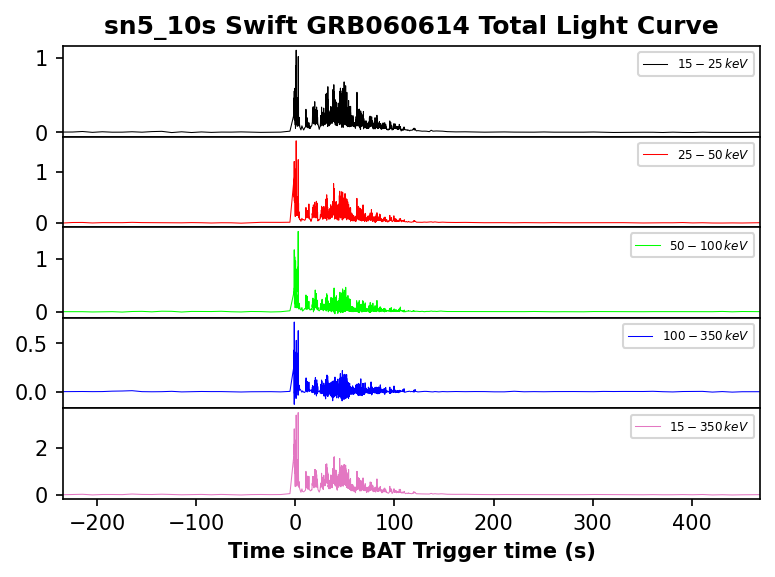

In [6]:
object1.end = "sn5_10s"
figure = object1.plot_any_grb(result_GRB[0], t=None)

and out of $T_{100}$:

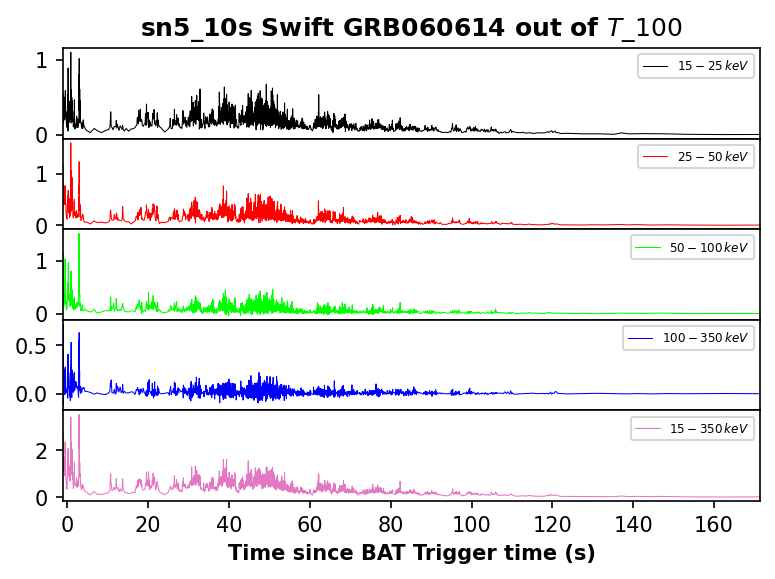

In [8]:
figure = object1.plot_any_grb(result_GRB[0], t=100)  # Plot Light Curve out of T_100

At this point, we again pre-process this dataset

In [ ]:
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]  # Use only non-error GRBs
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)  # Limit Data
normalized_data = object1.so_much_normalize(limited_data)  # Normalize Data
zero_padded_data = object1.so_much_zero_pad(normalized_data)  # Zero-pad data
pre_processing_data = object1.so_much_fourier(zero_padded_data)  # DFT to data
object1.save_data(f"DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save data
print(f"There are {len(errors)} GRBs that cannot be limited:")  # Print how many errors there are
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)  # Print Errors Table

and perform t-SNE:

In [8]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
print(f"There are {len(GRB_names)} GRBs loaded: {GRB_names}")
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start
pp = np.array([4, 5, 6, 7, 8, 9, 10, 15, 17, 20, 25, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450])
file_name = os.path.join('README_files', f'perplexity_animation_{object1.end}.gif')
# object1.tsne_animation(features, iterable='perplexity', perplexity=pp, library='sklearn', duration_s=durations, # filename=file_name)

Readable file created


![](README_files/perplexity_animation_sn5_10s.gif)

In [ ]:
output = os.system('jupyter nbconvert  README.ipynb --to markdown --output README.md')
output2 = os.system('jupyter nbconvert  README.ipynb --to html --output README.html')
print(f"Readable file created") if output == 0 else None